# Full Setup, Classifier and Convolutional Variational Autoencoders


The model follows [this](https://bytepawn.com/building-a-pytorch-autoencoder-for-mnist-digits.html) tutorial by Bytepawn (The Blog covers interesting computer science/astro physics crossover topics).
Visualizations ideas are taken from [this](https://skannai.medium.com/what-are-convolutional-variational-auto-encoders-cvae-515f4fedc23) blog ny Berke Türkmen.

In [1]:
import sys
sys.dont_write_bytecode = True

from os.path import dirname, abspath, join
import lightning as L
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor, EarlyStopping, StochasticWeightAveraging, GradientAccumulationScheduler
import json

import torch.nn as nn
import numpy as np
import torch, json, sys
from os.path import dirname, abspath, join
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from torch.utils.data import Dataset, DataLoader, random_split

sys.path.insert(1, '03_FullSetup')
from models import *
from utils import *
from data import *
device = "cuda" if torch.cuda.is_available() else "cpu"

torch.set_default_dtype(torch.float32)
torch.set_float32_matmul_precision('medium')

# TODO load from checkpoint

config = json.load(open('03_FullSetup/config.json'))
torch.manual_seed(config['seed']);


# set dtype, float64 is almost never necessary
dtype_default = torch.float32
torch.set_float32_matmul_precision("medium")
torch.set_default_dtype(dtype_default)
device = "cuda" if torch.cuda.is_available() else "cpu";

In [2]:
run_mode = 'inference'

dataMod = CVAE_MNIST_Data(config)
model = CVAE2(config, device, mode = 'conv') 
ckpt_path = "lightning_logs/VAE_Classifier/version_39/checkpoints/last.ckpt"
device = 'cpu'

if run_mode == 'inference':
    model = CVAE2.load_from_checkpoint(ckpt_path)
    model.eval()
elif run_mode =='fit':
    lr_monitor = LearningRateMonitor(logging_interval='step')
    logger = TensorBoardLogger("lightning_logs", name=config["model_name"])
    val_ckeckpoint = ModelCheckpoint( # saved in `trainer.default_root_dir`/`logger.version`/`checkpoint_callback.dirpath`
                filename="{epoch}-{step}-{val_loss:.8f}",
                monitor="val_loss",
                mode="min",
                save_top_k=2,
                save_last =True
                )
    callbacks = [lr_monitor, val_ckeckpoint]
    trainer = Trainer(enable_checkpointing=True, max_epochs=config["epochs"],
                        callbacks=callbacks, logger=logger)

    trainer.fit(model, ckpt_path=ckpt_path)

model.to(device)

CVAE2(
  (activation): ReLU()
  (sigmoid): Sigmoid()
  (log_likelihood): MSELoss()
  (encoder): ConvEncoder(
    (activation): ReLU()
    (encoder): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
      (9): Flatten(start_dim=1, end_dim=-1)
    )
  )
  (decoder): ConvDecoder(
    (activation): ReLU()
    (decoder): Sequential(
      (0): Linear(in_features=2, out_features=3136, bias=True)
      (1): Unflatten(dim=1, unflattened_size=(64, 7, 7))
      (2): ReLU()
      (3): C

# Generating new outputs 

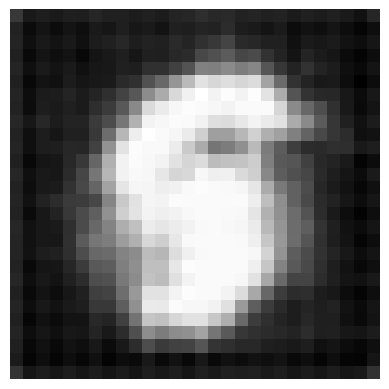

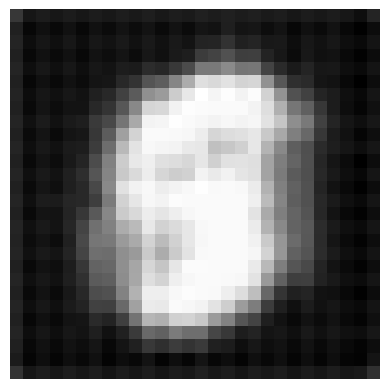

(None, None)

In [8]:
generate_digit(model, device, mean=2.5, var=1.0), generate_digit(model, device, mean=1.0, var=0.0)

# Confusion Matrix


# Feature Maps

[this](https://github.com/utkuozbulak/pytorch-cnn-visualizations) GitHub Repository provides visualization examples. Most of them are publications of themselves.

In [ ]:
print(dict([*model.named_modules()]).keys())
return_nodes = {
    'encoder.encoder.0': 'enc_0',
    'encoder.encoder.2': 'enc_1',
    'encoder.encoder.4': 'enc_2',
    'encoder.encoder.5': 'enc_3',
    'decoder.decoder.0': 'dec_0',
    'decoder.decoder.2': 'dec_1',
    'decoder.decoder.4': 'dec_2',
    'decoder.decoder.5': 'dec_3',
    'decoder.decoder.6': 'dec_4',
}
fe = FeatureExtractor(model, return_nodes)

dict_keys(['', 'activation', 'lossF', 'encoder', 'encoder.encoder', 'encoder.encoder.0', 'encoder.encoder.2', 'encoder.encoder.4', 'encoder.encoder.5', 'decoder', 'decoder.decoder', 'decoder.decoder.0', 'decoder.decoder.2', 'decoder.decoder.4', 'decoder.decoder.5', 'decoder.decoder.6'])


In [ ]:
dataMod.setup('test')
model = model.to('cpu')
model.c_device = 'cpu'
model.eval()
fe = fe.to('cpu')
fe.eval()
x_test, y_test = dataMod.train_dataset[1]
x_test = x_test.to('cpu')
y_pred = model(x_test).detach().numpy()


RuntimeError: mat1 and mat2 shapes cannot be multiplied (8x400 and 3200x20)

In [ ]:

dl = DataLoader(dataMod.test_dataset, batch_size=1, num_workers=1, persistent_workers=False, shuffle=False)
data_it = iter(dl)
fig = plt.figure(figsize=(12, 10))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(3,12), 
                 axes_pad=(0.1,0.4), 
                 )

im, label = next(data_it)
for ax in grid:
    data = next(data_it)
    im,label =  data
    im_fe = fe(next(data_it)).to('cpu')
    ax.imshow(im.reshape(28,28), cmap="gray")
    ax.set_title(label.item())
    ax.axis('off')

    


In [ ]:
dataMod
data_it = iter(test_loader)
for ax in grid:
    im, label = next(data_it)
    ax.imshow(im.reshape(28,28), cmap="gray")
    ax.set_title(label.item())
    ax.axis('off')

plt.show()

# Generate New Data

Variational Autoencoders are capable of generating **new** output by providing a sample for the latent distribution and feeding it to the decoder. 

- Latent space range
- generate some images
- interpolate

# Outlook

## Transfer Learning

## Domain Adaptation

## Specialized architectures

# Example for Feature Extraction (used for transfer learning)

from torchvision.models import resnet50
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.models.detection.mask_rcnn import MaskRCNN
from torchvision.models.detection.backbone_utils import LastLevelMaxPool
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork

# print all layers
train_nodes, eval_nodes = get_graph_node_names(model)

# specfy the iteresting ones


create_feature_extractor(model, return_nodes=return_nodes)